In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle5 as pickle
import re
# turn of warnings for this notebook
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression

# OLS Ensembling
 - Begin with predictions from the Arima and ConvLSTM models
 - Months Apr-Sep in years 2013-2014 are used as "dev" data to fit linear models incorporating the two predictions across the grid of CA predictions. Months Apr-Sep in 2015-2016 are used as the "test" data we are minimizing error for.
 - 3 splits of dev data for fitting lms: Aggregate (all predictions used to fit one lm), Individual Points (fit an lm for every grid point), and by Month (fit an lm for observations for each month)
 - Evaluation metric is mean absolute percent error (MAPE) 

## Read in Data

In [2]:
with open('all_data.pkl', 'rb') as f:
    ad = pickle.load(f)
    
ad.head()

,Year,Month,SCA,Landsat_Image,BW_SCA_Image,Color_SCA_Image,catdef,rzexc,evap,srfexc,sfmc,capac,Snowf,Rainf,prmc,sumwesn,runoff,Tair,RainfC,rzmc
0,2003,1,294585,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 38.347, 58.863, 72.956, 104.4...","[[nan, nan, nan, 2.8021, 3.8333, 3.6458, 2.835...","[[nan, nan, nan, 1.9842, 1.8075, 1.1867, 1.024...","[[nan, nan, nan, -0.25451, -0.26739, -0.30132,...","[[nan, nan, nan, 0.45009, 0.41456000000000004,...","[[nan, nan, nan, 0.07147200000000001, 0.069579...","[[nan, nan, nan, 0.0, 4.0366999999999995e-05, ...","[[nan, nan, nan, 9.8164, 9.1992, 7.3516, 5.421...","[[nan, nan, nan, 0.46491000000000005, 0.42658,...","[[nan, nan, nan, 1.9386e-05, 0.00053811, 0.009...","[[nan, nan, nan, 7.8125, 7.9023, 6.6211, 3.629...","[[nan, nan, nan, 284.14, 283.06, 281.55, 281.1...","[[nan, nan, nan, 0.12506, 0.12585, 0.10165, 0....","[[nan, nan, nan, 0.47278000000000003, 0.442019..."
1,2003,2,19185627,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 54.951, 79.32600000000001, 90...","[[nan, nan, nan, 1.7583, 1.871, 1.7959, 1.2065...","[[nan, nan, nan, 2.3223, 1.939, 1.5134, 1.5090...","[[nan, nan, nan, -0.48801000000000005, -0.486,...","[[nan, nan, nan, 0.43295, 0.39828, 0.36313, 0....","[[nan, nan, nan, 0.067444, 0.10471, 0.092987, ...","[[nan, nan, nan, 0.027298000000000003, 0.04013...","[[nan, nan, nan, 4.377, 4.3574, 3.7314, 2.8877...","[[nan, nan, nan, 0.45143, 0.40968999999999994,...","[[nan, nan, nan, 0.0026054000000000003, 0.0053...","[[nan, nan, nan, 3.4277, 3.8438, 3.5537, 2.386...","[[nan, nan, nan, 281.02, 279.66, 278.21, 278.1...","[[nan, nan, nan, 0.35803, 0.32971, 0.230590000...","[[nan, nan, nan, 0.45508000000000004, 0.42786,..."
2,2003,3,39522095,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 58.096000000000004, 80.846, 9...","[[nan, nan, nan, 3.0619, 3.3489999999999998, 2...","[[nan, nan, nan, 2.252, 2.0894, 1.7779, 1.9288...","[[nan, nan, nan, -0.28013000000000005, -0.2856...","[[nan, nan, nan, 0.43599, 0.40242, 0.365309999...","[[nan, nan, nan, 0.059937, 0.09848, 0.10797000...","[[nan, nan, nan, 0.00029898, 0.001753300000000...","[[nan, nan, nan, 8.875, 8.3047, 6.4688, 5.0547...","[[nan, nan, nan, 0.45028, 0.40975, 0.3652, 0.3...","[[nan, nan, nan, 1.5571999999999999e-06, 9.130...","[[nan, nan, nan, 5.7129, 5.6113, 4.375, 2.9229...","[[nan, nan, nan, 282.26, 281.13, 279.84, 279.9...","[[nan, nan, nan, 0.31006, 0.2572, 0.17047, 0.1...","[[nan, nan, nan, 0.4537, 0.42867, 0.38632, 0.3..."
3,2003,4,53739475,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 50.902, 74.34, 89.059, 98.902...","[[nan, nan, nan, 3.2247, 3.7618, 3.4259, 2.673...","[[nan, nan, nan, 2.4907, 2.2066, 2.021, 2.1504...","[[nan, nan, nan, -0.1607, -0.14800000000000002...","[[nan, nan, nan, 0.44292, 0.40849, 0.3726, 0.3...","[[nan, nan, nan, 0.079956, 0.12982, 0.19555999...","[[nan, nan, nan, 0.38354, 0.65161, 0.88013, 0....","[[nan, nan, nan, 8.6953, 8.5234, 7.334, 6.5078...","[[nan, nan, nan, 0.45588, 0.41511000000000003,...","[[nan, nan, nan, 0.074188, 0.14722000000000002...","[[nan, nan, nan, 6.0234, 6.3164, 5.4961, 4.298...","[[nan, nan, nan, 280.85, 279.66, 278.47, 278.7...","[[nan, nan, nan, 0.68433, 0.58594, 0.42126, 0....","[[nan, nan, nan, 0.46101000000000003, 0.43318,..."
4,2003,5,46363941,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 77.083, 103.3, 112.11, 113.8,...","[[nan, nan, nan, 0.016929, -0.53873, -0.45475,...","[

In [3]:
# confirm 33x37 grid and where measurements are non-null
print(ad['catdef'][0].shape)
for line in ad['catdef'][0]:
    print(line)

(33, 37)
[    nan     nan     nan  38.347  58.863  72.956 104.46  129.74   70.331
 211.3   474.3   602.55  626.55  827.8   672.05  640.55  577.55  673.8
 675.3   793.55  966.8   637.8   691.8   595.3   715.3   674.3   399.93
 267.3   295.68  319.18  419.93  363.8   354.93  483.43  664.05  853.55
 829.05 ]
[    nan     nan     nan  34.613  46.753  62.91   85.738 108.99  105.27
 180.11  318.3   452.05  520.8   663.05  629.55  728.05  677.55  668.55
 650.55  712.05  541.05  556.55  530.05  541.3   598.55  627.55  519.3
 383.68  338.55  333.05  360.18  334.68  330.3   386.8   665.3   859.55
 865.8  ]
[    nan     nan     nan     nan  61.785  70.206  95.456 117.68  128.93
 120.77  222.24  234.49  334.05  393.18  614.55  581.8   695.55  665.55
 566.55  467.18  314.8   297.55  273.18  438.68  665.8   817.8   800.05
 705.3   595.8   417.3   412.3   331.3   315.8   343.18  586.55  861.05
 835.55 ]
[    nan     nan     nan     nan  67.706  73.488  83.644  86.988  86.519
 115.08  104.11  161.93  

## Compile ARIMA catdef predictions
 - Compares locations to to CA regional grid array
 - Reads in prediction files from catdef_extraction_6mo_lambda and compiles into gridded catdef predictions

(33, 37)


<AxesSubplot:>

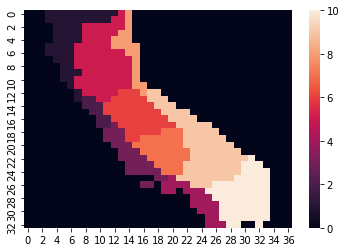

In [4]:
# get CA grid for comparison
# read in as np array
with open("region_mask.csv") as file_name:
    ca_grid = np.loadtxt(file_name, delimiter=",")

print(ca_grid.shape)
sns.heatmap(ca_grid)

<AxesSubplot:>

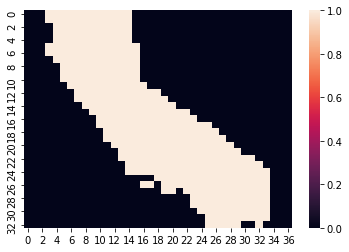

In [5]:
# confirms grid locations from csv filenames line up with CA grid above
# NOTE: use check_grid later for masking full catdef measurements
check_grid = np.zeros((33,37))
counter = 0
for fn in os.listdir('catdef_extraction_6mo_lambda/'):
    if fn.endswith('.preds.csv'):
        # extract x and y coords from filename
        reg_x = re.search('row.(\d+)', fn)
        coord_x = int(reg_x.group(1))

        reg_y = re.search('col.(\d+)', fn)
        coord_y = int(reg_y.group(1))
        
        check_grid[coord_x, coord_y] = 1
        
sns.heatmap(check_grid)

In [6]:
# First create nan arrays for arima predictions
###############################################
# helper function to put empty arrays into df
def create_na_arrs():
    a = np.empty((33,37))
    a[:] = np.nan
    return a

# get subset of timeframes of interest - Apr-Sep 2013 to 2016
ad_sm = ad[['Year', 'Month', 'catdef']].copy()
catdef_test_df = ad_sm[(ad_sm['Year'] >= 2013) & (ad_sm['Month'] >= 4) & (ad_sm['Month'] <= 9)]
catdef_test_df.reset_index(inplace=True, drop=True)
# add a column of all nan arrays
catdef_test_df['arima_preds'] = [create_na_arrs() for i in range(catdef_test_df.shape[0])]
catdef_test_df

,Year,Month,catdef,arima_preds
0,2013,4,"[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,2013,5,"[[nan, nan, nan, 147.88, 181.63, 188.63, 204.6...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,2013,6,"[[nan, nan, nan, 121.71, 163.49, 194.99, 225.6...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,2013,7,"[[nan, nan, nan, 167.07, 230.01, 264.82, 299.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,2013,8,"[[nan, nan, nan, 257.66, 324.35, 333.35, 360.3...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
5,2013,9,"[[nan, nan, nan, 285.1, 338.1, 337.73, 367.23,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
6,2014,4,"[[nan, nan, nan, 92.60600000000001, 107.79, 11...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
7,2014,5,"[[nan, nan, nan, 126.35, 156.82, 165.51, 190.2...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
8,2014,6,"[[nan, nan, nan, 191.03, 227.15, 230.15, 250.4...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
9,2014,7,"[[nan, nan, nan, 245.5, 292.57, 297.69, 321.07...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


In [7]:
# Loop to add in values for the predictions months from csv files
#################################################################
# ARIMA predictions are in directory catdef_extraction_6mo_lambda
for fn in os.listdir('catdef_extraction_6mo_lambda/'):
    if fn.endswith('.preds.csv'):
        # extract x and y coords from filename
        reg_y = re.search('row.(\d+)', fn)
        coord_y = int(reg_y.group(1))

        reg_x = re.search('col.(\d+)', fn)
        coord_x = int(reg_x.group(1))
        
        # Predict *from* months are 123, 135, 147, 159
        pred_from = [123, 135, 147, 159]
        
        # read in csv, subset to prediction months
        pred_df = pd.read_csv('catdef_extraction_6mo_lambda/' + fn)
        pred_df = pred_df[pred_df['end_month'].isin(pred_from)]
        # sort values just in case
        pred_df.sort_values(['end_month', 'pred_month'], inplace=True)
        pred_df.reset_index(inplace=True, drop = True)
        
        for i in range(catdef_test_df.shape[0]):
            catdef_test_df['arima_preds'][i][coord_y,coord_x] = pred_df['Point.Forecast'][i]
            
catdef_test_df

,Year,Month,catdef,arima_preds
0,2013,4,"[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, 66.7398951814242, 88.67098509..."
1,2013,5,"[[nan, nan, nan, 147.88, 181.63, 188.63, 204.6...","[[nan, nan, nan, 102.339907836972, 129.2146757..."
2,2013,6,"[[nan, nan, nan, 121.71, 163.49, 194.99, 225.6...","[[nan, nan, nan, 123.906814370616, 154.6877450..."
3,2013,7,"[[nan, nan, nan, 167.07, 230.01, 264.82, 299.2...","[[nan, nan, nan, 157.88604967341, 205.76766306..."
4,2013,8,"[[nan, nan, nan, 257.66, 324.35, 333.35, 360.3...","[[nan, nan, nan, 210.33331801029, 276.03185249..."
5,2013,9,"[[nan, nan, nan, 285.1, 338.1, 337.73, 367.23,...","[[nan, nan, nan, 243.694252233477, 302.9634131..."
6,2014,4,"[[nan, nan, nan, 92.60600000000001, 107.79, 11...","[[nan, nan, nan, 61.566668455968, 87.351125683..."
7,2014,5,"[[nan, nan, nan, 126.35, 156.82, 165.51, 190.2...","[[nan, nan, nan, 101.712063956104, 132.3127666..."
8,2014,6,"[[nan, nan, nan, 191.03, 227.15, 230.15, 250.4...","[[nan, nan, nan, 122.011224352017, 158.2947038..."
9,2014,7,"[[nan, nan, nan, 245.5, 292.57, 297.69, 321.07...","[[nan, nan, nan, 167.995487985376, 227.4662199..."


## Add ConvLSTM predictions

In [8]:
with open('convlstm_predictions.pkl', 'rb') as f:
    clstm = pickle.load(f)
    
clstm

,Month,predicted_catdef
0,123,"[nan, nan, nan, 85.938576, 103.544174, 110.915..."
1,124,"[nan, nan, nan, 130.21872, 160.34409, 169.3946..."
2,125,"[nan, nan, nan, 143.92606, 181.17183, 192.0754..."
3,126,"[nan, nan, nan, 203.37497, 250.97179, 261.5211..."
4,127,"[nan, nan, nan, 240.79918, 287.63943, 295.0433..."
5,128,"[nan, nan, nan, 227.76547, 268.82016, 275.5240..."
6,129,"[nan, nan, nan, 183.83089, 214.76942, 223.7646..."
7,130,"[nan, nan, nan, 188.42944, 219.72267, 227.1869..."
8,131,"[nan, nan, nan, 144.06348, 176.01228, 186.9007..."
9,132,"[nan, nan, nan, 148.31018, 181.59914, 189.5918..."


<AxesSubplot:>

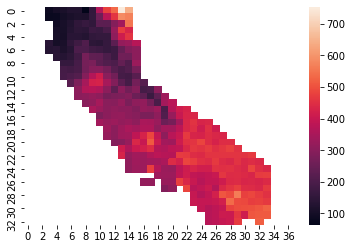

In [9]:
# confirm grid of measurements lines up
sns.heatmap(np.array(clstm['predicted_catdef'][0]).reshape((33,37)))

In [10]:
# subset to prediction periods months 123-128, 135-140, 147-152, 159-164
clstm_preds = clstm[((clstm['Month'] >= 123) & (clstm['Month'] <= 128))
                   |((clstm['Month'] >= 135) & (clstm['Month'] <= 140))
                   |((clstm['Month'] >= 147) & (clstm['Month'] <= 152))
                   |((clstm['Month'] >= 159) & (clstm['Month'] <= 164))]

# reshape into 33x37 array
clstm_preds['predicted_catdef'] = clstm_preds['predicted_catdef'].apply(lambda x: x.reshape((33,37)))

# reset index and rename col
clstm_preds.reset_index(inplace=True, drop=True)
clstm_preds.rename(columns = {'predicted_catdef': 'clstm_preds'}, inplace=True)

clstm_preds

,Month,clstm_preds
0,123,"[[nan, nan, nan, 85.938576, 103.544174, 110.91..."
1,124,"[[nan, nan, nan, 130.21872, 160.34409, 169.394..."
2,125,"[[nan, nan, nan, 143.92606, 181.17183, 192.075..."
3,126,"[[nan, nan, nan, 203.37497, 250.97179, 261.521..."
4,127,"[[nan, nan, nan, 240.79918, 287.63943, 295.043..."
5,128,"[[nan, nan, nan, 227.76547, 268.82016, 275.524..."
6,135,"[[nan, nan, nan, 71.17791, 94.615456, 106.0578..."
7,136,"[[nan, nan, nan, 121.402145, 151.52287, 161.19..."
8,137,"[[nan, nan, nan, 162.91061, 200.65712, 209.168..."
9,138,"[[nan, nan, nan, 238.11534, 281.49814, 286.444..."


In [11]:
# add clstm_preds to catdef_test_df
catdef_test_df['clstm_preds'] = clstm_preds['clstm_preds']

catdef_test_df

,Year,Month,catdef,arima_preds,clstm_preds
0,2013,4,"[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, 66.7398951814242, 88.67098509...","[[nan, nan, nan, 85.938576, 103.544174, 110.91..."
1,2013,5,"[[nan, nan, nan, 147.88, 181.63, 188.63, 204.6...","[[nan, nan, nan, 102.339907836972, 129.2146757...","[[nan, nan, nan, 130.21872, 160.34409, 169.394..."
2,2013,6,"[[nan, nan, nan, 121.71, 163.49, 194.99, 225.6...","[[nan, nan, nan, 123.906814370616, 154.6877450...","[[nan, nan, nan, 143.92606, 181.17183, 192.075..."
3,2013,7,"[[nan, nan, nan, 167.07, 230.01, 264.82, 299.2...","[[nan, nan, nan, 157.88604967341, 205.76766306...","[[nan, nan, nan, 203.37497, 250.97179, 261.521..."
4,2013,8,"[[nan, nan, nan, 257.66, 324.35, 333.35, 360.3...","[[nan, nan, nan, 210.33331801029, 276.03185249...","[[nan, nan, nan, 240.79918, 287.63943, 295.043..."
5,2013,9,"[[nan, nan, nan, 285.1, 338.1, 337.73, 367.23,...","[[nan, nan, nan, 243.694252233477, 302.9634131...","[[nan, nan, nan, 227.76547, 268.82016, 275.524..."
6,2014,4,"[[nan, nan, nan, 92.60600000000001, 107.79, 11...","[[nan, nan, nan, 61.566668455968, 87.351125683...","[[nan, nan, nan, 71.17791, 94.615456, 106.0578..."
7,2014,5,"[[nan, nan, nan, 126.35, 156.82, 165.51, 190.2...","[[nan, nan, nan, 101.712063956104, 132.3127666...","[[nan, nan, nan, 121.402145, 151.52287, 161.19..."
8,2014,6,"[[nan, nan, nan, 191.03, 227.15, 230.15, 250.4...","[[nan, nan, nan, 122.011224352017, 158.2947038...","[[nan, nan, nan, 162.91061, 200.65712, 209.168..."
9,2014,7,"[[nan, nan, nan, 245.5, 292.57, 297.69, 321.07...","[[nan, nan, nan, 167.995487985376, 227.4662199...","[[nan, nan, nan, 238.11534, 281.49814, 286.444..."


## Formatting Data for OLS Ensembling

<AxesSubplot:>

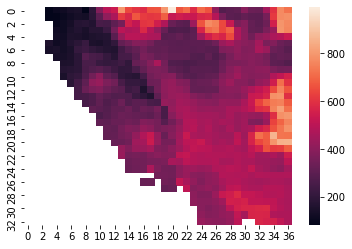

In [12]:
# Note catdef covers all landmass, preds only for CA pts
sns.heatmap(catdef_test_df['catdef'][0])

<AxesSubplot:>

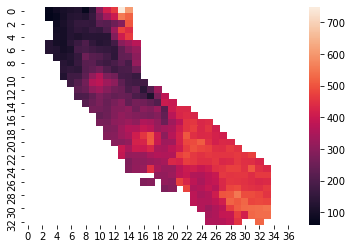

In [13]:
sns.heatmap(catdef_test_df['arima_preds'][0])

In [14]:
# create dict of records for iterating
pred_dict = catdef_test_df.to_dict('records')
pred_dict[:3]

[{'Year': 2013,
  'Month': 4,
  'catdef': array([[   nan,    nan,    nan, ..., 600.63, 769.88, 721.88],
         [   nan,    nan,    nan, ..., 616.88, 773.38, 781.13],
         [   nan,    nan,    nan, ..., 552.63, 789.63, 766.13],
         ...,
         [   nan,    nan,    nan, ..., 513.38, 484.5 , 469.  ],
         [   nan,    nan,    nan, ..., 478.  , 471.5 , 470.13],
         [   nan,    nan,    nan, ..., 555.88, 512.75, 470.25]]),
  'arima_preds': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'clstm_preds': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, 

In [15]:
# Breaks out into indivual grid point, obs and predictions by month
pred_df_list = []
for row in pred_dict:
    for y in range(33):
        for x in range(37):
            next_row = {}
            next_row['actual_catdef'] = row['catdef'][y,x]
            next_row['arima_pred'] = row['arima_preds'][y,x]
            next_row['clstm_pred'] = row['clstm_preds'][y,x]
            next_row['Month'] = row['Month']
            next_row['Year'] = row['Year']
            next_row['Coordinates'] = str(y) + ', ' + str(x)
            
            pred_df_list.append(next_row)

pred_df = pd.DataFrame(pred_df_list)
print(pred_df.shape)
pred_df

(29304, 6)


,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
0,NaN,NaN,NaN,4,2013,"0, 0"
1,NaN,NaN,NaN,4,2013,"0, 1"
2,NaN,NaN,NaN,4,2013,"0, 2"
3,85.939,66.739895,85.938576,4,2013,"0, 3"
4,109.030,88.670985,103.544174,4,2013,"0, 4"
...,...,...,...,...,...,...
29299,544.410,520.204214,517.391418,9,2016,"32, 32"
29300,554.660,NaN,NaN,9,2016,"32, 33"
29301,561.660,NaN,NaN,9,2016,"32, 34"
29302,513.910,NaN,NaN,9,2016,"32, 35"


In [16]:
# Observations are for ALL grid points
29304 / 24

1221.0

In [17]:
# dropping nulls gives us only preds for CA grid points
pred_df = pred_df.dropna()
print(pred_df.shape)
10560 / 24

(10560, 6)


440.0

# Linear Ensembling and Plotting:
 - 1) Aggregate linear model on all observations
 - 2) Linear models for each individual grid point
 - 3) Linear models for observations for each calendar month in training data (best performer)

In [19]:
# Plotting Function
###################
def plot_mape(df, year, title):
    sub_df = df[df['Year'] == year].copy()
    sub_df.reset_index(inplace=True, drop=True)

    fig, axs = plt.subplots(3, 6, figsize = (18,15))
    plt.suptitle(title)
    ###################################################################################################
    # First row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['arima_error'][0], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['arima_error'][0]) * 100, 1)
    axs[0,0].set(xlabel='April', ylabel='Arima Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['arima_error'][1]) * 100, 1)
    axs[0,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][2], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][2]) * 100, 1)
    axs[0,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][3], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][3]) * 100, 1)
    axs[0,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][4], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][4]) * 100, 1)
    axs[0,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][5], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                ax=axs[0,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][5]) * 100, 1)
    axs[0,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')

    ###################################################################################################
    # Second row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['clstm_error'][0], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['clstm_error'][0]) * 100, 1)
    axs[1,0].set(xlabel='April', ylabel='ConvLSTM Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['clstm_error'][1]) * 100, 1)
    axs[1,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][2], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][2]) * 100, 1)
    axs[1,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][3], 
                vmin=0, vmax=.5, 
                cmap='YlOrRd', 
                cbar=False, 
                ax=axs[1,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][3]) * 100, 1)
    axs[1,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][4], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][4]) * 100, 1)
    axs[1,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][5], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                ax=axs[1,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][5]) * 100, 1)
    axs[1,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')


    ###################################################################################################
    # Third row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['ensemble_error'][0], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['ensemble_error'][0]) * 100, 1)
    axs[2,0].set(xlabel='April', ylabel='Ensemble Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['ensemble_error'][1]) * 100, 1)
    axs[2,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][2],
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][2]) * 100, 1)
    axs[2,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][3], 
                vmin=0, vmax=.5,
                cmap='YlOrRd',
                cbar=False, 
                ax=axs[2,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][3]) * 100, 1)
    axs[2,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][4], 
                vmin=0, vmax=.5,
                cmap='YlOrRd',
                cbar=False, 
                ax=axs[2,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][4]) * 100, 1)
    axs[2,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][5],
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                ax=axs[2,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][5]) * 100, 1)
    axs[2,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')

    print()

## Aggregate Linear Model

In [20]:
# dev is years 2013-2014
dev_df = pred_df[pred_df['Year'] < 2015]
dev_df.shape

(5280, 6)

In [21]:
# create dummies
mon_dummies = pd.get_dummies(dev_df['Month']).rename(columns=lambda x: 'Month_' + str(x))
fit_df = pd.concat([dev_df, mon_dummies], axis=1)
fit_df.drop(['Month', 'Month_4', 'Year', 'Coordinates'], inplace=True, axis=1)
fit_df.reset_index(inplace=True, drop=True)
fit_df

,actual_catdef,arima_pred,clstm_pred,Month_5,Month_6,Month_7,Month_8,Month_9
0,85.939,66.739895,85.938576,0,0,0,0,0
1,109.030,88.670985,103.544174,0,0,0,0,0
2,122.280,105.710309,110.915077,0,0,0,0,0
3,143.500,113.746098,123.457626,0,0,0,0,0
4,148.690,120.348041,123.816002,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5275,385.560,376.506121,389.243256,0,0,0,0,1
5276,385.690,397.966578,387.297455,0,0,0,0,1
5277,399.310,397.350959,402.415131,0,0,0,0,1
5278,479.190,481.411834,465.049500,0,0,0,0,1


In [22]:
# split into y as predicted, other cols as predictors
y = fit_df[['actual_catdef']]
x_vars = fit_df.drop(['actual_catdef'], axis = 1)

# instantiate lm
lm = LinearRegression()

# fit lm
lm.fit(x_vars, y)

lm.coef_

array([[ 0.50615952,  0.4675623 ,  8.97062307, 16.09058322, 18.01713266,
         7.65004625,  6.58658877]])

In [23]:
# df to predict 2015 and 2016
test_df = pred_df[pred_df['Year'] > 2014]
test_df.shape

(5280, 6)

In [24]:
# create dummies
mon_dummies = pd.get_dummies(test_df['Month']).rename(columns=lambda x: 'Month_' + str(x))
predict_df = pd.concat([test_df, mon_dummies], axis=1)
predict_df.drop(['Month', 'Year', 'Coordinates', 'Month_4'], inplace=True, axis=1)
predict_df.reset_index(inplace=True, drop=True)
predict_df

,actual_catdef,arima_pred,clstm_pred,Month_5,Month_6,Month_7,Month_8,Month_9
0,107.42,95.308787,102.632980,0,0,0,0,0
1,129.48,111.618985,136.307449,0,0,0,0,0
2,143.92,128.346665,149.467422,0,0,0,0,0
3,191.05,167.711591,182.340515,0,0,0,0,0
4,206.67,173.657163,187.421051,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5275,401.03,400.607547,394.102661,0,0,0,0,1
5276,400.28,405.591886,391.481995,0,0,0,0,1
5277,402.66,397.354142,404.192413,0,0,0,0,1
5278,478.28,486.180000,466.108398,0,0,0,0,1


In [25]:
predicted_catdef = lm.predict(predict_df.drop(['actual_catdef'], axis=1))
predicted_catdef

array([[118.54249335],
       [142.54296771],
       [157.16294916],
       ...,
       [419.01003598],
       [492.91967   ],
       [534.11935655]])

## Rebuild array from preds, compare/plot error

In [26]:
predicted_catdef.shape

(5280, 1)

In [27]:
test_df['ens_predicted_catdef'] = predicted_catdef
test_df.head()

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef
14655,107.42,95.308787,102.632980,4,2015,"0, 3",118.542493
14656,129.48,111.618985,136.307449,4,2015,"0, 4",142.542968
14657,143.92,128.346665,149.467422,4,2015,"0, 5",157.162949
14658,191.05,167.711591,182.340515,4,2015,"0, 6",192.458100
14659,206.67,173.657163,187.421051,4,2015,"0, 7",197.842975


In [28]:
test_df['Year-Month'] = test_df['Year'].astype(str) + '-' + test_df['Month'].astype(str)
test_df.head()

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef,Year-Month
14655,107.42,95.308787,102.632980,4,2015,"0, 3",118.542493,2015-4
14656,129.48,111.618985,136.307449,4,2015,"0, 4",142.542968,2015-4
14657,143.92,128.346665,149.467422,4,2015,"0, 5",157.162949,2015-4
14658,191.05,167.711591,182.340515,4,2015,"0, 6",192.458100,2015-4
14659,206.67,173.657163,187.421051,4,2015,"0, 7",197.842975,2015-4


In [29]:
# build out predictions into arrays, add month/year to merge with existing data
pred_df_list = []
for ym in test_df['Year-Month'].unique():
    output_row = {}
    
    # get year/month to match with og data
    yr, mo = ym.split('-')
    output_row['Year'] = yr
    output_row['Month'] = mo
    
    # break rows into list of dicts
    sub_df = test_df[test_df['Year-Month']==ym]
    pred_dicts = sub_df.to_dict('records')
    
    # create array of nans to populate
    a = np.empty((33,37))
    a[:] = np.nan
    
    # populate with point predictions
    for p in pred_dicts:
        coord_y, coord_x = p['Coordinates'].split(', ')
        a[int(coord_y), int(coord_x)] = p['ens_predicted_catdef']
        
    output_row['ensemble_pred_catdef'] = a
    
    pred_df_list.append(output_row)
    
predictions_array_df = pd.DataFrame(pred_df_list)
predictions_array_df

,Year,Month,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 118.54249334693499, 142.54296..."
1,2015,5,"[[nan, nan, nan, 159.06193092596897, 180.49343..."
2,2015,6,"[[nan, nan, nan, 191.7231101972749, 228.035139..."
3,2015,7,"[[nan, nan, nan, 243.10067020566106, 291.41244..."
4,2015,8,"[[nan, nan, nan, 275.1711375063292, 321.393912..."
5,2015,9,"[[nan, nan, nan, 283.7000269082002, 320.714174..."
6,2016,4,"[[nan, nan, nan, 96.12353728643961, 114.169176..."
7,2016,5,"[[nan, nan, nan, 136.62499020924065, 160.11201..."
8,2016,6,"[[nan, nan, nan, 178.13583961064546, 210.01132..."
9,2016,7,"[[nan, nan, nan, 236.11033183770257, 283.79036..."


<AxesSubplot:>

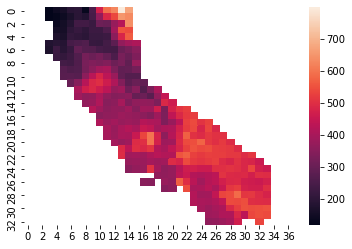

In [30]:
sns.heatmap(predictions_array_df['ensemble_pred_catdef'][0])

## Merge data all into one clean comparison df

In [32]:
# create year_month again to merge on
predictions_array_df['Year-Month'] = predictions_array_df['Year'].astype(str) + '-' + predictions_array_df['Month'].astype(str)
catdef_test_df['Year-Month'] = catdef_test_df['Year'].astype(str) + '-' + catdef_test_df['Month'].astype(str)


final_pred_df = catdef_test_df[catdef_test_df['Year'] > 2014]
final_pred_df = final_pred_df.merge(predictions_array_df, on = ['Year-Month'])
print(final_pred_df.shape)
final_pred_df.drop(['Year-Month', 'Year_y', 'Month_y'], axis = 1, inplace=True)
final_pred_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month'}, inplace=True)
final_pred_df.head()

(12, 9)


,Year,Month,catdef,arima_preds,clstm_preds,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 107.42, 129.48, 143.92, 191.0...","[[nan, nan, nan, 95.3087869354875, 111.6189852...","[[nan, nan, nan, 102.63298, 136.30745, 149.467...","[[nan, nan, nan, 118.54249334693499, 142.54296..."
1,2015,5,"[[nan, nan, nan, 153.2, 176.08, 180.45, 219.26...","[[nan, nan, nan, 135.658782430562, 143.9159212...","[[nan, nan, nan, 126.4272, 163.32512, 175.3835...","[[nan, nan, nan, 159.06193092596897, 180.49343..."
2,2015,6,"[[nan, nan, nan, 205.2, 244.07, 247.32, 278.63...","[[nan, nan, nan, 138.476067407405, 172.4432124...","[[nan, nan, nan, 178.0037, 218.895, 227.39644,...","[[nan, nan, nan, 191.7231101972749, 228.035139..."
3,2015,7,"[[nan, nan, nan, 273.9, 321.28, 321.4, 349.65,...","[[nan, nan, nan, 180.93178138614, 238.64429423...","[[nan, nan, nan, 237.80673, 278.65698, 283.539...","[[nan, nan, nan, 243.10067020566106, 291.41244..."
4,2015,8,"[[nan, nan, nan, 317.01, 343.39, 338.89, 368.6...","[[nan, nan, nan, 244.399689124637, 298.5787650...","[[nan, nan, nan, 259.86298, 300.0705, 303.2366...","[[nan, nan, nan, 275.1711375063292, 321.393912..."


## Analyze and Plot Prediction Errors

<AxesSubplot:>

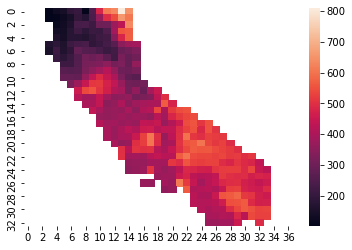

In [33]:
# create masked catdef only for predicted gridpoints
def apply_mask(arr):
    # Note: uses check_grid defined earlier
    m_arr = arr * check_grid
    m_arr[m_arr==0] = ['nan']
    
    return m_arr

final_pred_df['catdef_masked'] = final_pred_df['catdef'].apply(apply_mask)
sns.heatmap(final_pred_df['catdef_masked'][0])

<AxesSubplot:>

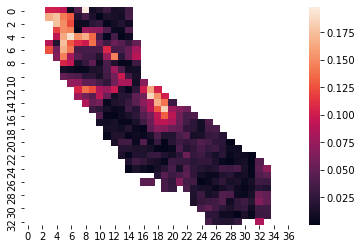

In [34]:
# Incorporate mean absolute percent error
final_pred_df['arima_error'] = abs((final_pred_df['arima_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])
final_pred_df['clstm_error'] = abs((final_pred_df['clstm_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])  
final_pred_df['ensemble_error'] = abs((final_pred_df['ensemble_pred_catdef'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])

sns.heatmap(final_pred_df['ensemble_error'][0])

<AxesSubplot:>

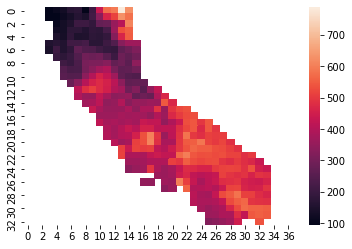

In [35]:
sns.heatmap(final_pred_df['arima_preds'][0])

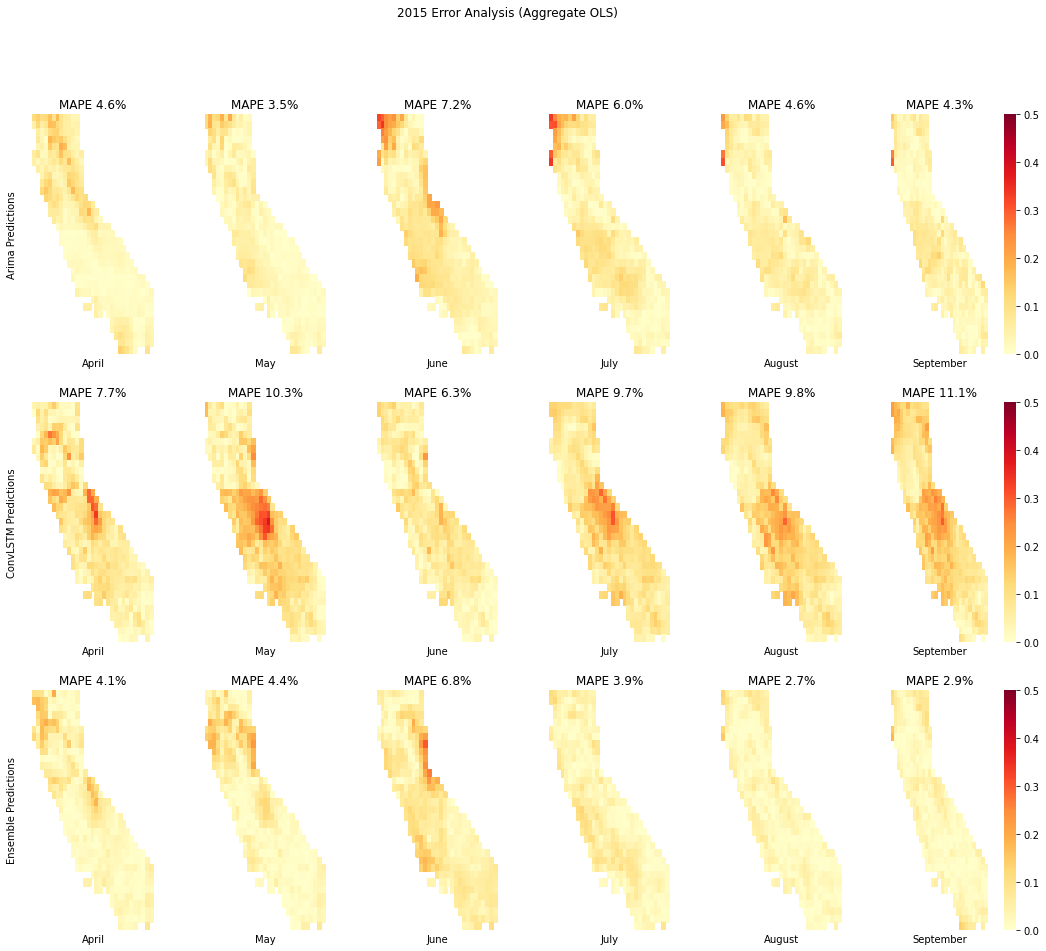

In [36]:
plot_mape(final_pred_df, 2015, "2015 Error Analysis (Aggregate OLS)")

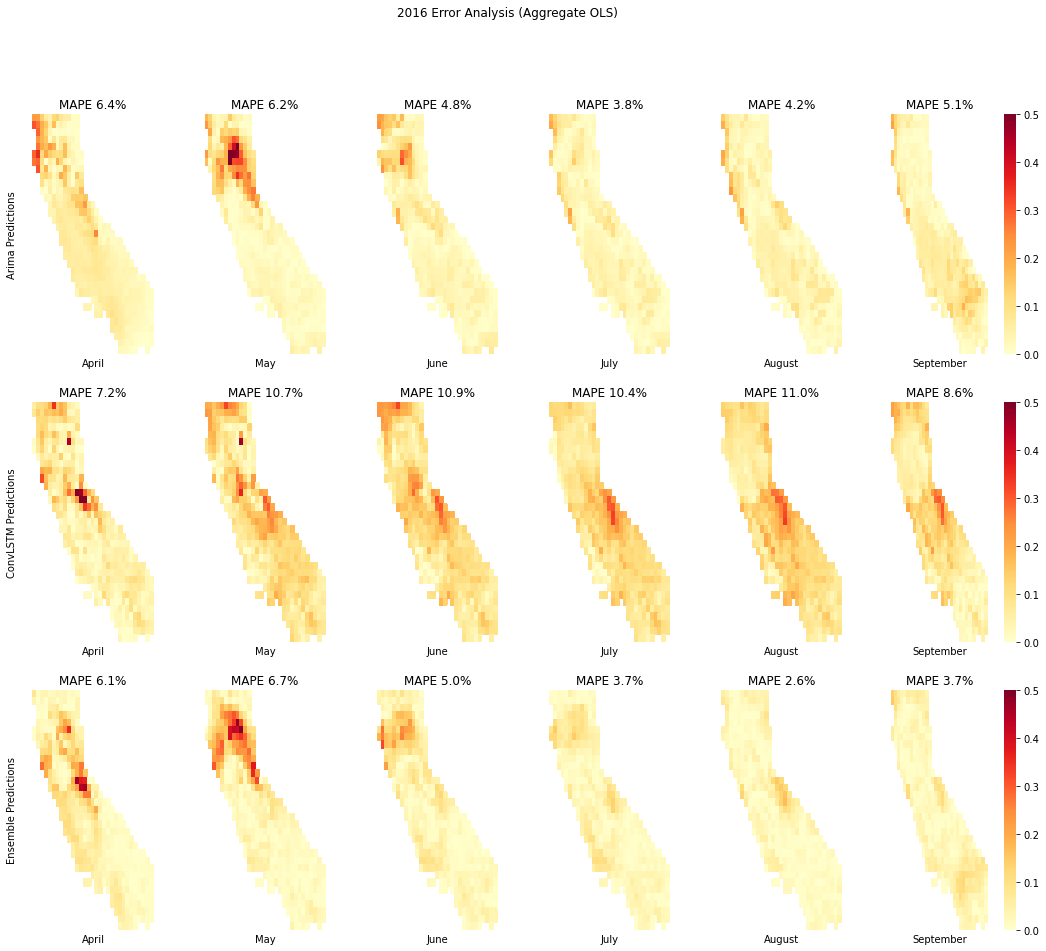

In [37]:
plot_mape(final_pred_df, 2016, "2016 Error Analysis (Aggregate OLS)")

## Linear Ensemble Model for Each Individual Grid Point

In [38]:
# working from dev_df
dev_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
3,85.939,66.739895,85.938576,4,2013,"0, 3"
4,109.030,88.670985,103.544174,4,2013,"0, 4"
5,122.280,105.710309,110.915077,4,2013,"0, 5"
6,143.500,113.746098,123.457626,4,2013,"0, 6"
7,148.690,120.348041,123.816002,4,2013,"0, 7"
...,...,...,...,...,...,...
14641,385.560,376.506121,389.243256,9,2014,"32, 26"
14642,385.690,397.966578,387.297455,9,2014,"32, 27"
14643,399.310,397.350959,402.415131,9,2014,"32, 28"
14644,479.190,481.411834,465.049500,9,2014,"32, 29"


In [39]:
test_df = pred_df[pred_df['Year'] > 2014]
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
14655,107.42,95.308787,102.632980,4,2015,"0, 3"
14656,129.48,111.618985,136.307449,4,2015,"0, 4"
14657,143.92,128.346665,149.467422,4,2015,"0, 5"
14658,191.05,167.711591,182.340515,4,2015,"0, 6"
14659,206.67,173.657163,187.421051,4,2015,"0, 7"
...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26"
29294,400.28,405.591886,391.481995,9,2016,"32, 27"
29295,402.66,397.354142,404.192413,9,2016,"32, 28"
29296,478.28,486.180000,466.108398,9,2016,"32, 29"


In [40]:
# create a column of 0s on test_df to populate with predictions
test_df['ens_predicted_catdef'] = 0
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef
14655,107.42,95.308787,102.632980,4,2015,"0, 3",0
14656,129.48,111.618985,136.307449,4,2015,"0, 4",0
14657,143.92,128.346665,149.467422,4,2015,"0, 5",0
14658,191.05,167.711591,182.340515,4,2015,"0, 6",0
14659,206.67,173.657163,187.421051,4,2015,"0, 7",0
...,...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26",0
29294,400.28,405.591886,391.481995,9,2016,"32, 27",0
29295,402.66,397.354142,404.192413,9,2016,"32, 28",0
29296,478.28,486.180000,466.108398,9,2016,"32, 29",0


In [41]:
# need to include coords this time for subsetting in next part
# adding dummies
mon_dummies = pd.get_dummies(dev_df['Month']).rename(columns=lambda x: 'Month_' + str(x))
fit_df = pd.concat([dev_df, mon_dummies], axis=1)
fit_df.drop(['Month', 'Month_4', 'Year'], inplace=True, axis=1)
fit_df.reset_index(inplace=True, drop=True)
fit_df

,actual_catdef,arima_pred,clstm_pred,Coordinates,Month_5,Month_6,Month_7,Month_8,Month_9
0,85.939,66.739895,85.938576,"0, 3",0,0,0,0,0
1,109.030,88.670985,103.544174,"0, 4",0,0,0,0,0
2,122.280,105.710309,110.915077,"0, 5",0,0,0,0,0
3,143.500,113.746098,123.457626,"0, 6",0,0,0,0,0
4,148.690,120.348041,123.816002,"0, 7",0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
5275,385.560,376.506121,389.243256,"32, 26",0,0,0,0,1
5276,385.690,397.966578,387.297455,"32, 27",0,0,0,0,1
5277,399.310,397.350959,402.415131,"32, 28",0,0,0,0,1
5278,479.190,481.411834,465.049500,"32, 29",0,0,0,0,1


In [42]:
# and do the same for predictions df
# create dummies
mon_dummies = pd.get_dummies(test_df['Month']).rename(columns=lambda x: 'Month_' + str(x))
predict_df = pd.concat([test_df, mon_dummies], axis=1)
predict_df.drop(['Month', 'Year', 'Month_4'], inplace=True, axis=1)
predict_df.reset_index(inplace=True, drop=True)
predict_df

,actual_catdef,arima_pred,clstm_pred,Coordinates,ens_predicted_catdef,Month_5,Month_6,Month_7,Month_8,Month_9
0,107.42,95.308787,102.632980,"0, 3",0,0,0,0,0,0
1,129.48,111.618985,136.307449,"0, 4",0,0,0,0,0,0
2,143.92,128.346665,149.467422,"0, 5",0,0,0,0,0,0
3,191.05,167.711591,182.340515,"0, 6",0,0,0,0,0,0
4,206.67,173.657163,187.421051,"0, 7",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5275,401.03,400.607547,394.102661,"32, 26",0,0,0,0,0,1
5276,400.28,405.591886,391.481995,"32, 27",0,0,0,0,0,1
5277,402.66,397.354142,404.192413,"32, 28",0,0,0,0,0,1
5278,478.28,486.180000,466.108398,"32, 29",0,0,0,0,0,1


In [43]:
# create a model for each coord, predict, and put values back in test_df
for cc in fit_df['Coordinates'].unique():
    # fit lm
    ########
    # subset
    fit_sub = fit_df[fit_df['Coordinates'] == cc]
    # split into y as predicted, other cols as predictors
    y = fit_sub[['actual_catdef']]
    x_vars = fit_sub.drop(['actual_catdef', 'Coordinates'], axis = 1)
    # instantiate lm
    lm = LinearRegression()
    # fit lm
    lm.fit(x_vars, y)
    
    # predict
    #########
    pred_sub = predict_df[predict_df['Coordinates'] == cc]
    predicted_catdef = lm.predict(pred_sub.drop(['actual_catdef', 'Coordinates', 'ens_predicted_catdef'], axis=1))
    
    # Possible add RMSE or confidence intervals here
    
    # put predictions back onto test_df
    ###################################
    #print(test_df[test_df['Coordinates'] == cc]['ens_predicted_catdef'].shape)
    test_df.loc[test_df['Coordinates'] == cc, 'ens_predicted_catdef'] = predicted_catdef
    
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef
14655,107.42,95.308787,102.632980,4,2015,"0, 3",90.944086
14656,129.48,111.618985,136.307449,4,2015,"0, 4",186.874146
14657,143.92,128.346665,149.467422,4,2015,"0, 5",179.700137
14658,191.05,167.711591,182.340515,4,2015,"0, 6",172.118082
14659,206.67,173.657163,187.421051,4,2015,"0, 7",177.618400
...,...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26",359.544632
29294,400.28,405.591886,391.481995,9,2016,"32, 27",382.515504
29295,402.66,397.354142,404.192413,9,2016,"32, 28",398.886135
29296,478.28,486.180000,466.108398,9,2016,"32, 29",472.852287


## Rebuild Arrays and plot

In [44]:
test_df['Year-Month'] = test_df['Year'].astype(str) + '-' + test_df['Month'].astype(str)

# build out predictions into arrays, add month/year to merge with existing data
pred_df_list = []
for ym in test_df['Year-Month'].unique():
    output_row = {}
    
    # get year/month to match with og data
    yr, mo = ym.split('-')
    output_row['Year'] = yr
    output_row['Month'] = mo
    
    # break rows into list of dicts
    sub_df = test_df[test_df['Year-Month']==ym]
    pred_dicts = sub_df.to_dict('records')
    
    # create array of nans to populate
    a = np.empty((33,37))
    a[:] = np.nan
    
    # populate with point predictions
    for p in pred_dicts:
        coord_y, coord_x = p['Coordinates'].split(', ')
        a[int(coord_y), int(coord_x)] = p['ens_predicted_catdef']
        
    output_row['ensemble_pred_catdef'] = a
    
    pred_df_list.append(output_row)
    
predictions_array_df = pd.DataFrame(pred_df_list)
predictions_array_df

,Year,Month,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 90.94408613269943, 186.874145..."
1,2015,5,"[[nan, nan, nan, 75.60446382647177, 175.855738..."
2,2015,6,"[[nan, nan, nan, 188.63240899795375, 256.18843..."
3,2015,7,"[[nan, nan, nan, 215.1344156185398, 272.513183..."
4,2015,8,"[[nan, nan, nan, 249.71842442440087, 338.41337..."
5,2015,9,"[[nan, nan, nan, 274.9822829764651, 350.249957..."
6,2016,4,"[[nan, nan, nan, 93.25132613048592, 113.718840..."
7,2016,5,"[[nan, nan, nan, 76.2773878651177, 83.65688767..."
8,2016,6,"[[nan, nan, nan, 89.73732627443525, 124.819250..."
9,2016,7,"[[nan, nan, nan, 109.40139527168915, 189.34414..."


In [45]:
# create year_month again to merge on
predictions_array_df['Year-Month'] = predictions_array_df['Year'].astype(str) + '-' + predictions_array_df['Month'].astype(str)
catdef_test_df['Year-Month'] = catdef_test_df['Year'].astype(str) + '-' + catdef_test_df['Month'].astype(str)


final_pred_df = catdef_test_df[catdef_test_df['Year'] > 2014]
final_pred_df = final_pred_df.merge(predictions_array_df, on = ['Year-Month'])
print(final_pred_df.shape)
final_pred_df.drop(['Year-Month', 'Year_y', 'Month_y'], axis = 1, inplace=True)
final_pred_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month'}, inplace=True)
final_pred_df

(12, 9)


,Year,Month,catdef,arima_preds,clstm_preds,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 107.42, 129.48, 143.92, 191.0...","[[nan, nan, nan, 95.3087869354875, 111.6189852...","[[nan, nan, nan, 102.63298, 136.30745, 149.467...","[[nan, nan, nan, 90.94408613269943, 186.874145..."
1,2015,5,"[[nan, nan, nan, 153.2, 176.08, 180.45, 219.26...","[[nan, nan, nan, 135.658782430562, 143.9159212...","[[nan, nan, nan, 126.4272, 163.32512, 175.3835...","[[nan, nan, nan, 75.60446382647177, 175.855738..."
2,2015,6,"[[nan, nan, nan, 205.2, 244.07, 247.32, 278.63...","[[nan, nan, nan, 138.476067407405, 172.4432124...","[[nan, nan, nan, 178.0037, 218.895, 227.39644,...","[[nan, nan, nan, 188.63240899795375, 256.18843..."
3,2015,7,"[[nan, nan, nan, 273.9, 321.28, 321.4, 349.65,...","[[nan, nan, nan, 180.93178138614, 238.64429423...","[[nan, nan, nan, 237.80673, 278.65698, 283.539...","[[nan, nan, nan, 215.1344156185398, 272.513183..."
4,2015,8,"[[nan, nan, nan, 317.01, 343.39, 338.89, 368.6...","[[nan, nan, nan, 244.399689124637, 298.5787650...","[[nan, nan, nan, 259.86298, 300.0705, 303.2366...","[[nan, nan, nan, 249.71842442440087, 338.41337..."
5,2015,9,"[[nan, nan, nan, 321.16, 341.78, 335.53, 367.5...","[[nan, nan, nan, 272.330259782286, 316.9433841...","[[nan, nan, nan, 250.1424, 281.01056, 283.0671...","[[nan, nan, nan, 274.9822829764651, 350.249957..."
6,2016,4,"[[nan, nan, nan, 88.51700000000001, 113.08, 12...","[[nan, nan, nan, 68.6571506461656, 88.14016892...","[[nan, nan, nan, 83.53611, 101.039925, 109.106...","[[nan, nan, nan, 93.25132613048592, 113.718840..."
7,2016,5,"[[nan, nan, nan, 133.52, 158.02, 159.95, 180.0...","[[nan, nan, nan, 109.343312793199, 136.8057345...","[[nan, nan, nan, 106.92795, 127.431435, 135.15...","[[nan, nan, nan, 76.2773878651177, 83.65688767..."
8,2016,6,"[[nan, nan, nan, 185.22, 225.34, 235.22, 259.7...","[[nan, nan, nan, 144.240360078723, 178.4164686...","[[nan, nan, nan, 142.70375, 173.88017, 183.376...","[[nan, nan, nan, 89.73732627443525, 124.819250..."
9,2016,7,"[[nan, nan, nan, 236.88, 285.07, 296.07, 319.8...","[[nan, nan, nan, 195.884413571035, 247.9642808...","[[nan, nan, nan, 206.66916, 252.26588, 261.685...","[[nan, nan, nan, 109.40139527168915, 189.34414..."


<AxesSubplot:>

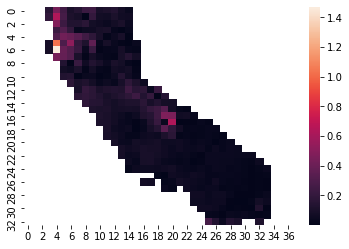

In [46]:
# create catdef only for predicted gridpoints
def apply_mask(arr):
    # Note: uses check_grid defined earlier
    m_arr = arr * check_grid
    m_arr[m_arr==0] = ['nan']
    
    return m_arr

final_pred_df['catdef_masked'] = final_pred_df['catdef'].apply(apply_mask)

final_pred_df['arima_error'] = abs((final_pred_df['arima_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])
final_pred_df['clstm_error'] = abs((final_pred_df['clstm_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])  
final_pred_df['ensemble_error'] = abs((final_pred_df['ensemble_pred_catdef'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])

sns.heatmap(final_pred_df['ensemble_error'][0])

## Plot Error

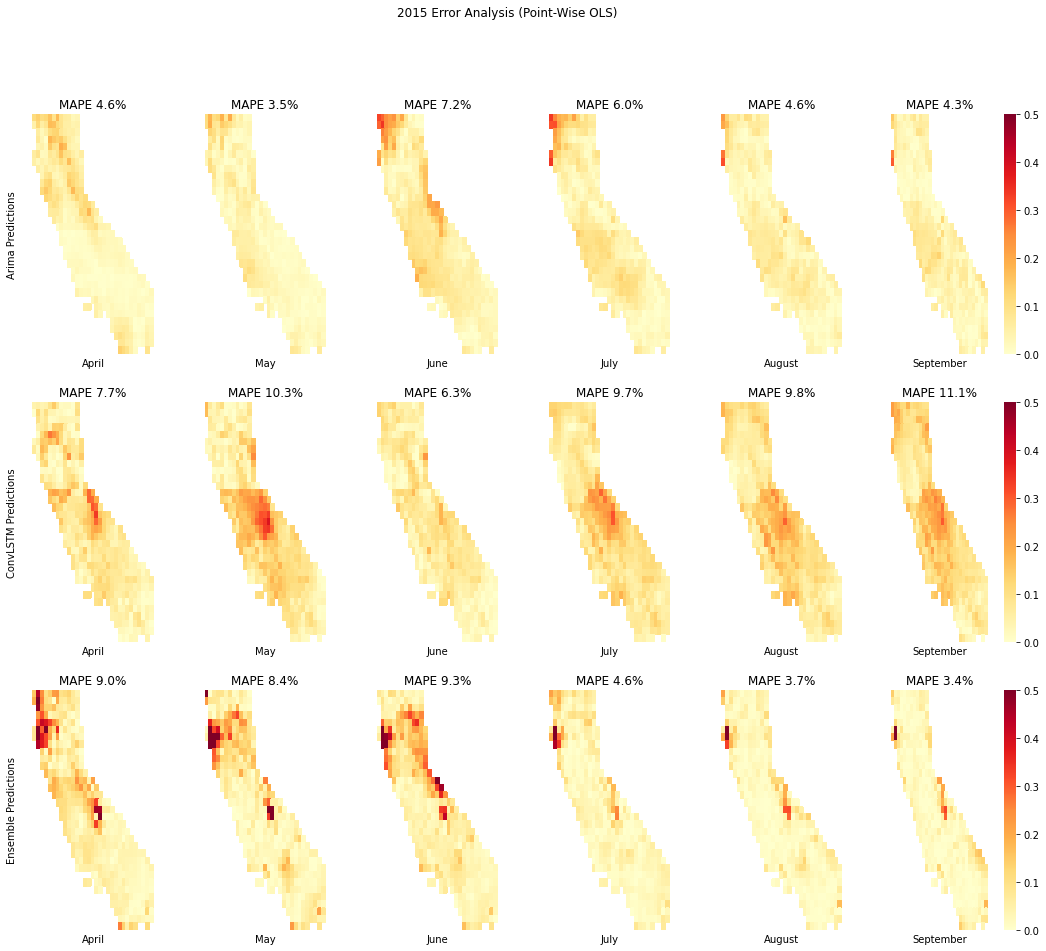

In [47]:
plot_mape(final_pred_df, 2015, "2015 Error Analysis (Point-Wise OLS)")

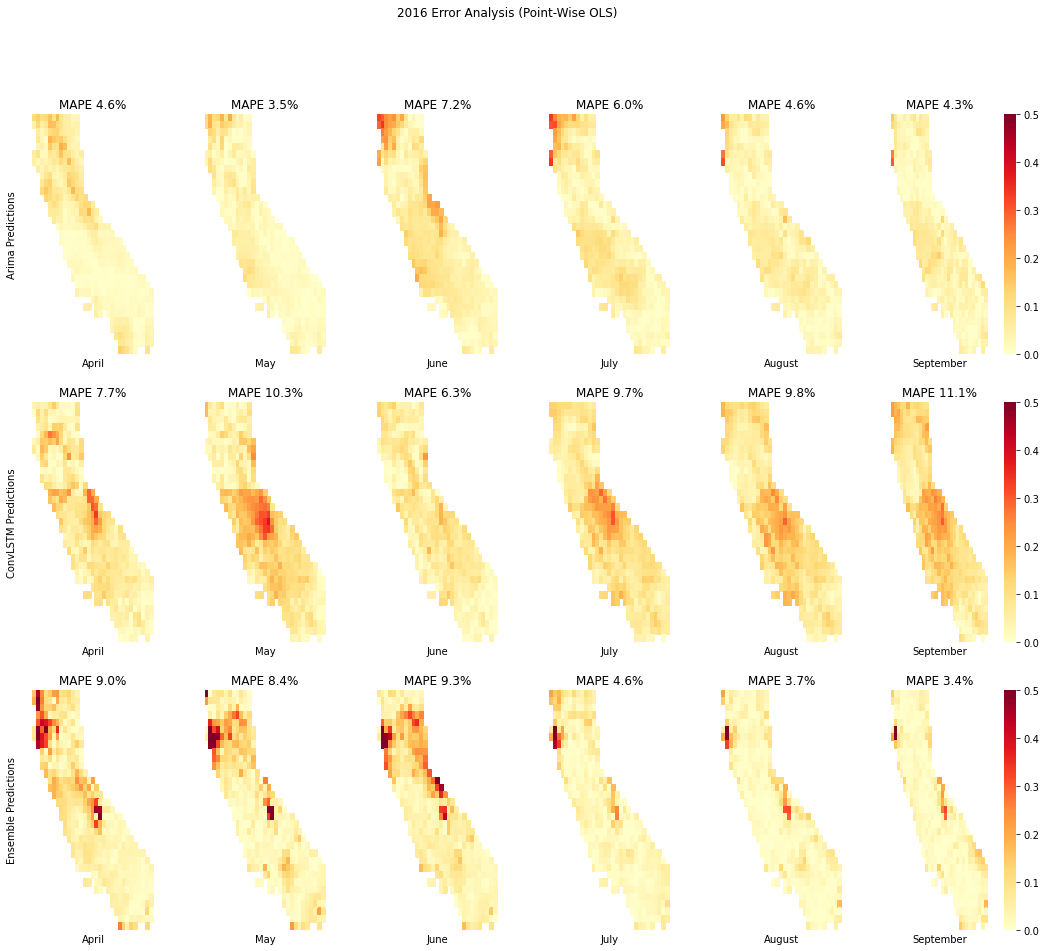

In [48]:
plot_mape(final_pred_df, 2015, "2016 Error Analysis (Point-Wise OLS)")

## OLS by Month

In [49]:
# working from dev_df
dev_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
3,85.939,66.739895,85.938576,4,2013,"0, 3"
4,109.030,88.670985,103.544174,4,2013,"0, 4"
5,122.280,105.710309,110.915077,4,2013,"0, 5"
6,143.500,113.746098,123.457626,4,2013,"0, 6"
7,148.690,120.348041,123.816002,4,2013,"0, 7"
...,...,...,...,...,...,...
14641,385.560,376.506121,389.243256,9,2014,"32, 26"
14642,385.690,397.966578,387.297455,9,2014,"32, 27"
14643,399.310,397.350959,402.415131,9,2014,"32, 28"
14644,479.190,481.411834,465.049500,9,2014,"32, 29"


In [50]:
test_df = pred_df[pred_df['Year'] > 2014]
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
14655,107.42,95.308787,102.632980,4,2015,"0, 3"
14656,129.48,111.618985,136.307449,4,2015,"0, 4"
14657,143.92,128.346665,149.467422,4,2015,"0, 5"
14658,191.05,167.711591,182.340515,4,2015,"0, 6"
14659,206.67,173.657163,187.421051,4,2015,"0, 7"
...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26"
29294,400.28,405.591886,391.481995,9,2016,"32, 27"
29295,402.66,397.354142,404.192413,9,2016,"32, 28"
29296,478.28,486.180000,466.108398,9,2016,"32, 29"


In [51]:
# create a column of 0s on test_df to populate with predictions
test_df['ens_predicted_catdef'] = 0
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef
14655,107.42,95.308787,102.632980,4,2015,"0, 3",0
14656,129.48,111.618985,136.307449,4,2015,"0, 4",0
14657,143.92,128.346665,149.467422,4,2015,"0, 5",0
14658,191.05,167.711591,182.340515,4,2015,"0, 6",0
14659,206.67,173.657163,187.421051,4,2015,"0, 7",0
...,...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26",0
29294,400.28,405.591886,391.481995,9,2016,"32, 27",0
29295,402.66,397.354142,404.192413,9,2016,"32, 28",0
29296,478.28,486.180000,466.108398,9,2016,"32, 29",0


In [52]:
# need to include coords this time for subsetting in next part
fit_df = dev_df.drop(['Year', 'Coordinates'], axis=1)
fit_df.reset_index(inplace=True, drop=True)
fit_df

,actual_catdef,arima_pred,clstm_pred,Month
0,85.939,66.739895,85.938576,4
1,109.030,88.670985,103.544174,4
2,122.280,105.710309,110.915077,4
3,143.500,113.746098,123.457626,4
4,148.690,120.348041,123.816002,4
...,...,...,...,...
5275,385.560,376.506121,389.243256,9
5276,385.690,397.966578,387.297455,9
5277,399.310,397.350959,402.415131,9
5278,479.190,481.411834,465.049500,9


In [53]:
# and do the same for predictions df
predict_df = test_df.drop(['Year', 'Coordinates'], axis=1)
predict_df.reset_index(inplace=True, drop=True)
predict_df

,actual_catdef,arima_pred,clstm_pred,Month,ens_predicted_catdef
0,107.42,95.308787,102.632980,4,0
1,129.48,111.618985,136.307449,4,0
2,143.92,128.346665,149.467422,4,0
3,191.05,167.711591,182.340515,4,0
4,206.67,173.657163,187.421051,4,0
...,...,...,...,...,...
5275,401.03,400.607547,394.102661,9,0
5276,400.28,405.591886,391.481995,9,0
5277,402.66,397.354142,404.192413,9,0
5278,478.28,486.180000,466.108398,9,0


In [54]:
# create a model for each month, predict, and put values back in test_df
for mo in fit_df['Month'].unique():
    # fit lm
    ########
    # subset
    fit_sub = fit_df[fit_df['Month'] == mo]
    # split into y as predicted, other cols as predictors
    y = fit_sub[['actual_catdef']]
    x_vars = fit_sub.drop(['actual_catdef', 'Month'], axis = 1)
    # instantiate lm
    lm = LinearRegression()
    # fit lm
    lm.fit(x_vars, y)
    
    # predict
    #########
    pred_sub = predict_df[predict_df['Month'] == mo]
    predicted_catdef = lm.predict(pred_sub.drop(['actual_catdef', 'Month', 'ens_predicted_catdef'], axis=1))
    
    # Possible add RMSE or confidence intervals here
    
    # put predictions back onto test_df
    ###################################
    #print(test_df[test_df['Coordinates'] == cc]['ens_predicted_catdef'].shape)
    test_df.loc[test_df['Month'] == mo, 'ens_predicted_catdef'] = predicted_catdef
    
test_df


,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,ens_predicted_catdef
14655,107.42,95.308787,102.632980,4,2015,"0, 3",118.848769
14656,129.48,111.618985,136.307449,4,2015,"0, 4",139.107379
14657,143.92,128.346665,149.467422,4,2015,"0, 5",154.510508
14658,191.05,167.711591,182.340515,4,2015,"0, 6",191.237053
14659,206.67,173.657163,187.421051,4,2015,"0, 7",196.813161
...,...,...,...,...,...,...,...
29293,401.03,400.607547,394.102661,9,2016,"32, 26",412.551396
29294,400.28,405.591886,391.481995,9,2016,"32, 27",414.923380
29295,402.66,397.354142,404.192413,9,2016,"32, 28",413.632541
29296,478.28,486.180000,466.108398,9,2016,"32, 29",489.988464


## Rebuild Arrays and Plot

In [55]:
test_df['Year-Month'] = test_df['Year'].astype(str) + '-' + test_df['Month'].astype(str)

# build out predictions into arrays, add month/year to merge with existing data
pred_df_list = []
for ym in test_df['Year-Month'].unique():
    output_row = {}
    
    # get year/month to match with og data
    yr, mo = ym.split('-')
    output_row['Year'] = yr
    output_row['Month'] = mo
    
    # break rows into list of dicts
    sub_df = test_df[test_df['Year-Month']==ym]
    pred_dicts = sub_df.to_dict('records')
    
    # create array of nans to populate
    a = np.empty((33,37))
    a[:] = np.nan
    
    # populate with point predictions
    for p in pred_dicts:
        coord_y, coord_x = p['Coordinates'].split(', ')
        a[int(coord_y), int(coord_x)] = p['ens_predicted_catdef']
        
    output_row['ensemble_pred_catdef'] = a
    
    pred_df_list.append(output_row)
    
predictions_array_df = pd.DataFrame(pred_df_list)
predictions_array_df

,Year,Month,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 118.8487687305222, 139.107379..."
1,2015,5,"[[nan, nan, nan, 155.3389512413832, 179.353023..."
2,2015,6,"[[nan, nan, nan, 195.0830570926378, 233.506773..."
3,2015,7,"[[nan, nan, nan, 239.1087327613757, 288.251433..."
4,2015,8,"[[nan, nan, nan, 276.4337878839726, 322.143859..."
5,2015,9,"[[nan, nan, nan, 285.1662589568599, 323.444332..."
6,2016,4,"[[nan, nan, nan, 94.77772785881557, 113.265105..."
7,2016,5,"[[nan, nan, nan, 133.31817722850866, 156.38450..."
8,2016,6,"[[nan, nan, nan, 172.56234414799673, 204.37008..."
9,2016,7,"[[nan, nan, nan, 233.55674217336616, 281.73058..."


In [56]:
# create year_month again to merge on
predictions_array_df['Year-Month'] = predictions_array_df['Year'].astype(str) + '-' + predictions_array_df['Month'].astype(str)
catdef_test_df['Year-Month'] = catdef_test_df['Year'].astype(str) + '-' + catdef_test_df['Month'].astype(str)


final_pred_df = catdef_test_df[catdef_test_df['Year'] > 2014]
final_pred_df = final_pred_df.merge(predictions_array_df, on = ['Year-Month'])
print(final_pred_df.shape)
final_pred_df.drop(['Year-Month', 'Year_y', 'Month_y'], axis = 1, inplace=True)
final_pred_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month'}, inplace=True)
final_pred_df

(12, 9)


,Year,Month,catdef,arima_preds,clstm_preds,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 107.42, 129.48, 143.92, 191.0...","[[nan, nan, nan, 95.3087869354875, 111.6189852...","[[nan, nan, nan, 102.63298, 136.30745, 149.467...","[[nan, nan, nan, 118.8487687305222, 139.107379..."
1,2015,5,"[[nan, nan, nan, 153.2, 176.08, 180.45, 219.26...","[[nan, nan, nan, 135.658782430562, 143.9159212...","[[nan, nan, nan, 126.4272, 163.32512, 175.3835...","[[nan, nan, nan, 155.3389512413832, 179.353023..."
2,2015,6,"[[nan, nan, nan, 205.2, 244.07, 247.32, 278.63...","[[nan, nan, nan, 138.476067407405, 172.4432124...","[[nan, nan, nan, 178.0037, 218.895, 227.39644,...","[[nan, nan, nan, 195.0830570926378, 233.506773..."
3,2015,7,"[[nan, nan, nan, 273.9, 321.28, 321.4, 349.65,...","[[nan, nan, nan, 180.93178138614, 238.64429423...","[[nan, nan, nan, 237.80673, 278.65698, 283.539...","[[nan, nan, nan, 239.1087327613757, 288.251433..."
4,2015,8,"[[nan, nan, nan, 317.01, 343.39, 338.89, 368.6...","[[nan, nan, nan, 244.399689124637, 298.5787650...","[[nan, nan, nan, 259.86298, 300.0705, 303.2366...","[[nan, nan, nan, 276.4337878839726, 322.143859..."
5,2015,9,"[[nan, nan, nan, 321.16, 341.78, 335.53, 367.5...","[[nan, nan, nan, 272.330259782286, 316.9433841...","[[nan, nan, nan, 250.1424, 281.01056, 283.0671...","[[nan, nan, nan, 285.1662589568599, 323.444332..."
6,2016,4,"[[nan, nan, nan, 88.51700000000001, 113.08, 12...","[[nan, nan, nan, 68.6571506461656, 88.14016892...","[[nan, nan, nan, 83.53611, 101.039925, 109.106...","[[nan, nan, nan, 94.77772785881557, 113.265105..."
7,2016,5,"[[nan, nan, nan, 133.52, 158.02, 159.95, 180.0...","[[nan, nan, nan, 109.343312793199, 136.8057345...","[[nan, nan, nan, 106.92795, 127.431435, 135.15...","[[nan, nan, nan, 133.31817722850866, 156.38450..."
8,2016,6,"[[nan, nan, nan, 185.22, 225.34, 235.22, 259.7...","[[nan, nan, nan, 144.240360078723, 178.4164686...","[[nan, nan, nan, 142.70375, 173.88017, 183.376...","[[nan, nan, nan, 172.56234414799673, 204.37008..."
9,2016,7,"[[nan, nan, nan, 236.88, 285.07, 296.07, 319.8...","[[nan, nan, nan, 195.884413571035, 247.9642808...","[[nan, nan, nan, 206.66916, 252.26588, 261.685...","[[nan, nan, nan, 233.55674217336616, 281.73058..."


<AxesSubplot:>

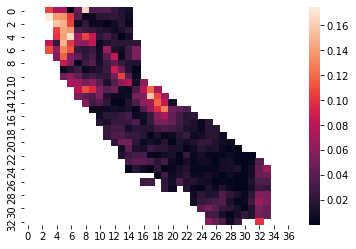

In [57]:
# create catdef only for predicted gridpoints
def apply_mask(arr):
    # Note: uses check_grid defined earlier
    m_arr = arr * check_grid
    m_arr[m_arr==0] = ['nan']
    
    return m_arr

final_pred_df['catdef_masked'] = final_pred_df['catdef'].apply(apply_mask)

final_pred_df['arima_error'] = abs((final_pred_df['arima_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])
final_pred_df['clstm_error'] = abs((final_pred_df['clstm_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])  
final_pred_df['ensemble_error'] = abs((final_pred_df['ensemble_pred_catdef'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])

sns.heatmap(final_pred_df['ensemble_error'][0])

## Plot Error

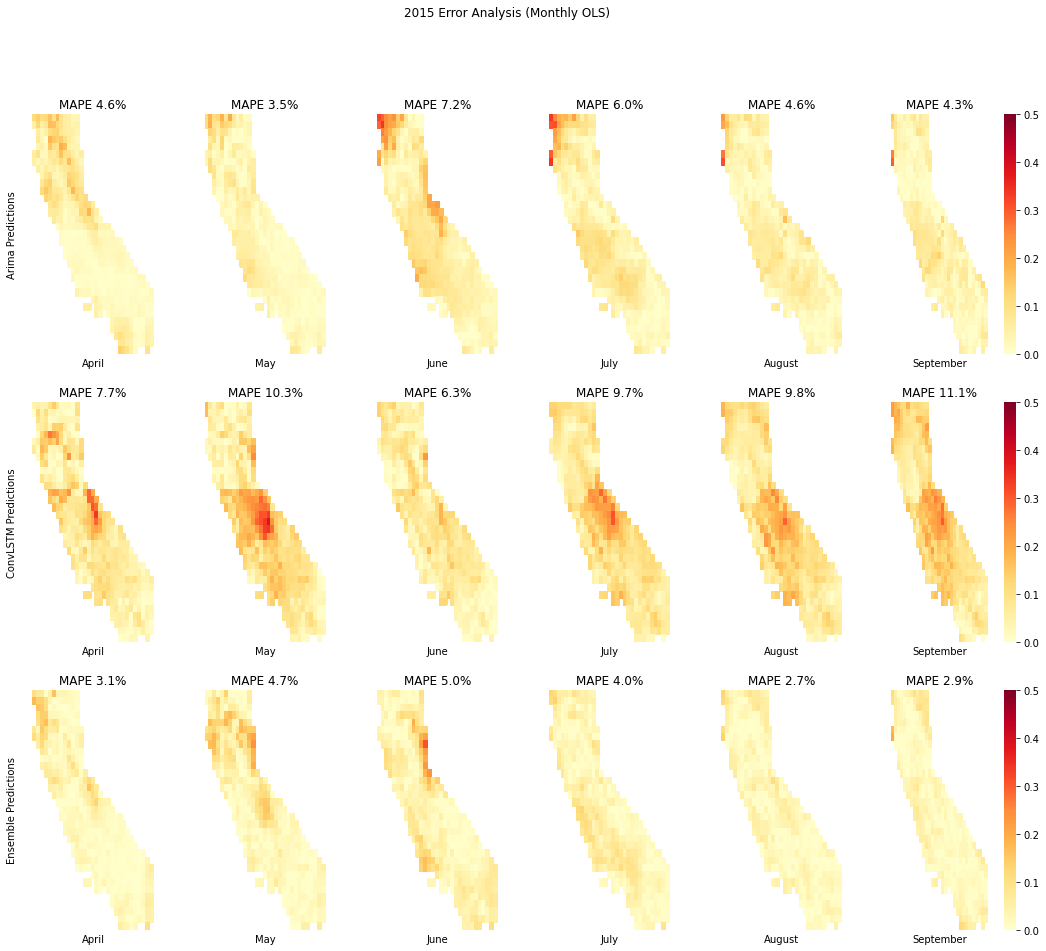

In [58]:
plot_mape(final_pred_df, 2015, "2015 Error Analysis (Monthly OLS)")

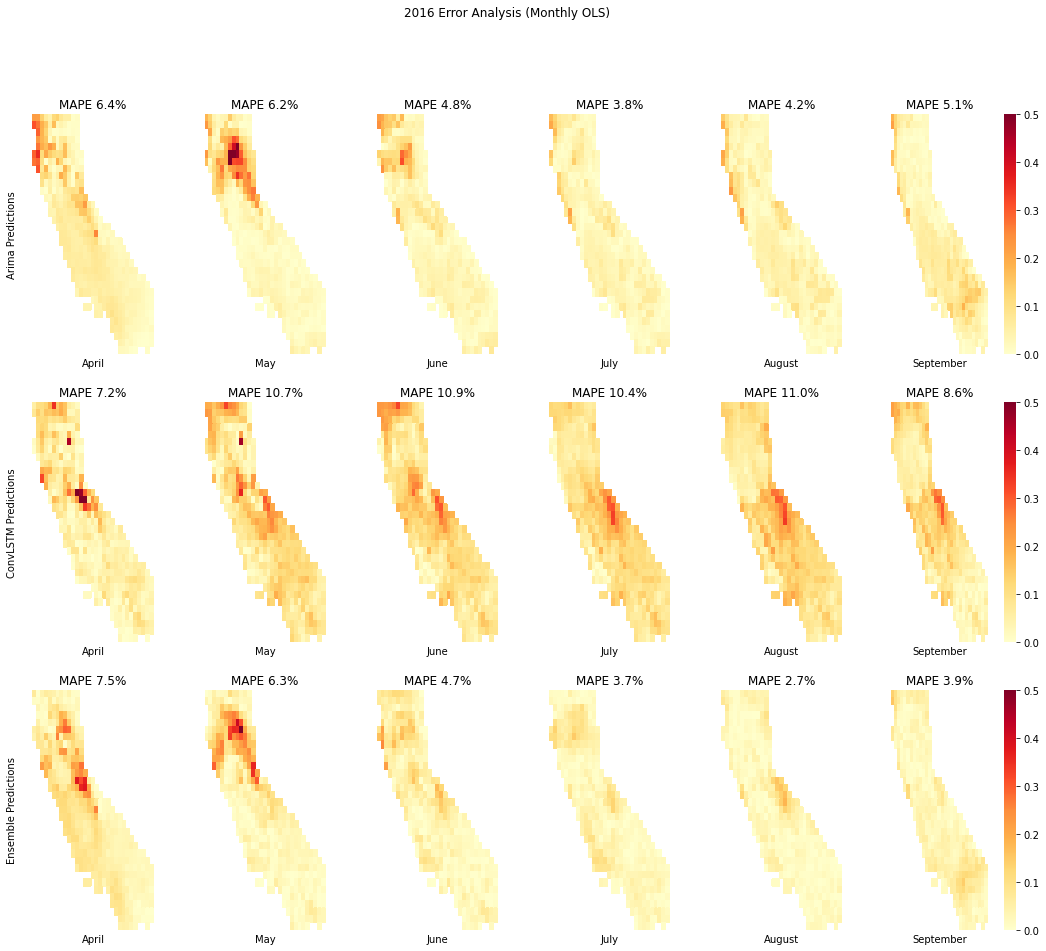

In [59]:
plot_mape(final_pred_df, 2016, "2016 Error Analysis (Monthly OLS)")

# Time Series Comparisons of catdef/arima/convlstm/ensemble

<AxesSubplot:>

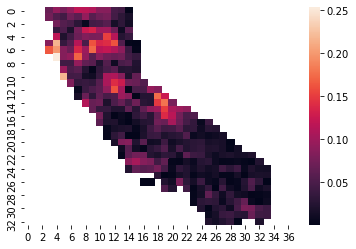

In [171]:
# look at a grid to get some idea of pts that would be interesting to plot

# [4,14] looks like a high-error point and is in Northern CA
# [20,24] looks like low error and is in Desert/Southern CA
sns.heatmap(final_pred_df['ensemble_error'][8])

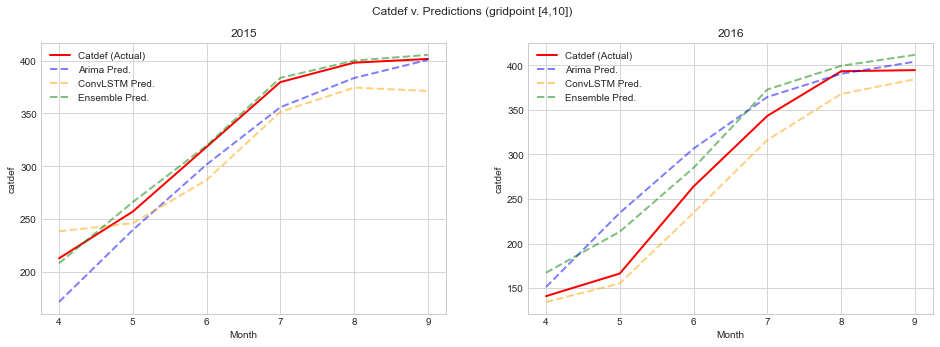

In [61]:
plt.style.use('seaborn-whitegrid')
# subset/select data
####################
# 2015
pred_15 = final_pred_df[final_pred_df['Year'] == 2015].copy()
# first just get a months list
l_mos = list(pred_15['Month'])
# and individual measures/predictions
l_catdef15 = [pred_15['catdef'][i][4,10] for i in range(6)]
l_arima15 = [pred_15['arima_preds'][i][4,10] for i in range(6)]
l_clstm15 = [pred_15['clstm_preds'][i][4,10] for i in range(6)]
l_ens15 = [pred_15['ensemble_pred_catdef'][i][4,10] for i in range(6)]

# 2016
pred_16 = final_pred_df[final_pred_df['Year'] == 2016].copy()
pred_16.reset_index(inplace=True, drop=True)
# first just get a months list
l_mos = list(pred_16['Month'])
# and individual measures/predictions
l_catdef16 = [pred_16['catdef'][i][4,10] for i in range(6)]
l_arima16 = [pred_16['arima_preds'][i][4,10] for i in range(6)]
l_clstm16 = [pred_16['clstm_preds'][i][4,10] for i in range(6)]
l_ens16 = [pred_16['ensemble_pred_catdef'][i][4,10] for i in range(6)]

# Plot
######
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Catdef v. Predictions (gridpoint [4,10])')
ax1.plot(l_mos, l_catdef15, c='Red', linewidth=2, label='Catdef (Actual)')
ax1.plot(l_mos, l_arima15, c='Blue', linestyle='--', linewidth=2, alpha=.5, label='Arima Pred.')
ax1.plot(l_mos, l_clstm15, c='Orange', linestyle='--', linewidth=2, alpha=.5, label='ConvLSTM Pred.')
ax1.plot(l_mos, l_ens15, c='Green', linestyle='--', linewidth=2, alpha=.5, label='Ensemble Pred.')
ax1.set_title('2015')
ax1.set_xlabel('Month')
ax1.set_ylabel('catdef')
ax1.legend()

ax2.plot(l_mos, l_catdef16, c='Red', linewidth=2, label='Catdef (Actual)')
ax2.plot(l_mos, l_arima16, c='Blue', linestyle='--', linewidth=2, alpha=.5, label='Arima Pred.')
ax2.plot(l_mos, l_clstm16, c='Orange', linestyle='--', linewidth=2, alpha=.5, label='ConvLSTM Pred.')
ax2.plot(l_mos, l_ens16, c='Green', linestyle='--', linewidth=2, alpha=.5, label='Ensemble Pred.')
ax2.set_title('2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('catdef')
ax2.legend()

print()

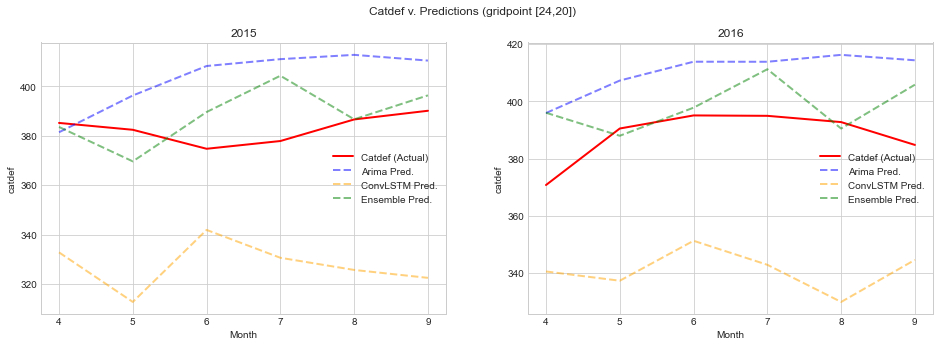

In [62]:
plt.style.use('seaborn-whitegrid')

# subset/select data
####################
# 2015
pred_15 = final_pred_df[final_pred_df['Year'] == 2015].copy()
# first just get a months list
l_mos = list(pred_15['Month'])
# and individual measures/predictions
l_catdef15 = [pred_15['catdef'][i][24,20] for i in range(6)]
l_arima15 = [pred_15['arima_preds'][i][24,20] for i in range(6)]
l_clstm15 = [pred_15['clstm_preds'][i][24,20] for i in range(6)]
l_ens15 = [pred_15['ensemble_pred_catdef'][i][24,20] for i in range(6)]

# 2016
pred_16 = final_pred_df[final_pred_df['Year'] == 2016].copy()
pred_16.reset_index(inplace=True, drop=True)
# first just get a months list
l_mos = list(pred_16['Month'])
# and individual measures/predictions
l_catdef16 = [pred_16['catdef'][i][24,20] for i in range(6)]
l_arima16 = [pred_16['arima_preds'][i][24,20] for i in range(6)]
l_clstm16 = [pred_16['clstm_preds'][i][24,20] for i in range(6)]
l_ens16 = [pred_16['ensemble_pred_catdef'][i][24,20] for i in range(6)]

# Plot
######
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Catdef v. Predictions (gridpoint [24,20])')
ax1.plot(l_mos, l_catdef15, c='Red', linewidth=2, label='Catdef (Actual)')
ax1.plot(l_mos, l_arima15, c='Blue', linestyle='--', linewidth=2, alpha=.5, label='Arima Pred.')
ax1.plot(l_mos, l_clstm15, c='Orange', linestyle='--', linewidth=2, alpha=.5, label='ConvLSTM Pred.')
ax1.plot(l_mos, l_ens15, c='Green', linestyle='--', linewidth=2, alpha=.5, label='Ensemble Pred.')
ax1.set_title('2015')
ax1.set_xlabel('Month')
ax1.set_ylabel('catdef')
ax1.legend()

ax2.plot(l_mos, l_catdef16, c='Red', linewidth=2, label='Catdef (Actual)')
ax2.plot(l_mos, l_arima16, c='Blue', linestyle='--', linewidth=2, alpha=.5, label='Arima Pred.')
ax2.plot(l_mos, l_clstm16, c='Orange', linestyle='--', linewidth=2, alpha=.5, label='ConvLSTM Pred.')
ax2.plot(l_mos, l_ens16, c='Green', linestyle='--', linewidth=2, alpha=.5, label='Ensemble Pred.')
ax2.set_title('2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('catdef')
ax2.legend()

print()